In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import optuna

warnings.simplefilter('ignore', FutureWarning)

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [3]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/04/train_april.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/04/test_april.csv')

In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

## Chuẩn hóa

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Chọn feature

In [6]:
top_features =  ['CAPE', 'KX', 'R500', 'R850', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B10B', 'B11B', 'B14B', 'I2B', 'I4B', 'IRB', 'WVB']

## Hàm bổ trợ

In [7]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [8]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, top_features=None):
    model_rf = RandomForestClassifier(random_state=42)
    
    if top_features is not None:
        X_train = X_train[top_features]
        X_test = X_test[top_features]

    model_rf.fit(X_train, y_train)
    
    y_pred = model_rf.predict(X_test)
    
    print_scores(y_test, y_pred)

In [9]:
def objective(trial, X_train_scaled, y_train, X_test_scaled, y_test, 
              use_smote=False, use_smoteenn=False, top_features=None):
    # Tối ưu hóa các tham số cho Random Forest
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),  
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']), 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    # Sử dụng top_features để chọn các đặc trưng quan trọng
    if top_features is not None:
        X_train_scaled = X_train_scaled[top_features]
        X_test_scaled = X_test_scaled[top_features]

    model = RandomForestClassifier(**param)
    model.fit(X_train_scaled, y_train)
    
    # Dự đoán xác suất và tối ưu hóa threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    best_thresh = trial.suggest_float('threshold', 0.1, 0.9, step=0.05)
    y_pred = (y_probs >= best_thresh).astype(int)

    return f1_score(y_test, y_pred, pos_label=1)


In [10]:
def optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,
                       use_smote=False, use_smoteenn=False,
                       top_features=None,
                       n_trials=20, timeout=1200):  
    study = optuna.create_study(direction='maximize')
    
    study.optimize(lambda trial: objective(trial, X_train_scaled, y_train, X_test_scaled, y_test,
                                           use_smote, use_smoteenn, top_features),
                   n_trials=n_trials, timeout=timeout)

    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    best_params = study.best_trial.params
    best_thresh = best_params.pop('threshold')

    best_params.update({
        'random_state': 42,
        'n_jobs': -1
    })
    
    best_model = RandomForestClassifier(**best_params)
    best_model.fit(X_train_scaled, y_train)

    y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_thresh = (y_probs >= best_thresh).astype(int)

    print(f"Best threshold: {best_thresh}")
    print_scores(y_test, y_pred_thresh)

# Không SMOTE

## Data

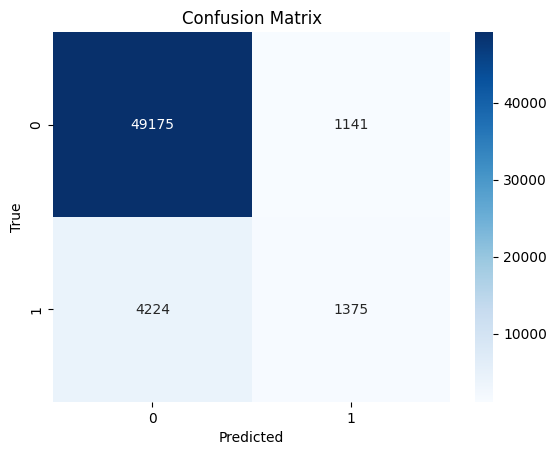

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     50316
           1       0.55      0.25      0.34      5599

    accuracy                           0.90     55915
   macro avg       0.73      0.61      0.64     55915
weighted avg       0.88      0.90      0.89     55915



In [11]:
train_and_evaluate_rf(X_train_scaled, y_train, X_test_scaled, y_test)

## Data tune

[I 2025-05-05 17:39:07,178] A new study created in memory with name: no-name-cbe9e870-d115-4097-81f9-eff9b293787d
[I 2025-05-05 17:41:50,450] Trial 0 finished with value: 0.3966339410939691 and parameters: {'n_estimators': 275, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.25}. Best is trial 0 with value: 0.3966339410939691.
[I 2025-05-05 17:43:47,753] Trial 1 finished with value: 0.3304473304473305 and parameters: {'n_estimators': 248, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.25}. Best is trial 0 with value: 0.3966339410939691.
[I 2025-05-05 17:45:08,882] Trial 2 finished with value: 0.3945149037532995 and parameters: {'n_estimators': 207, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.6}. Best is tr

Best trial:
FrozenTrial(number=0, state=1, values=[0.3966339410939691], datetime_start=datetime.datetime(2025, 5, 5, 17, 39, 7, 179941), datetime_complete=datetime.datetime(2025, 5, 5, 17, 41, 50, 450259), params={'n_estimators': 275, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.25}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=0, value=None)
Best hyperparameters:
n_est

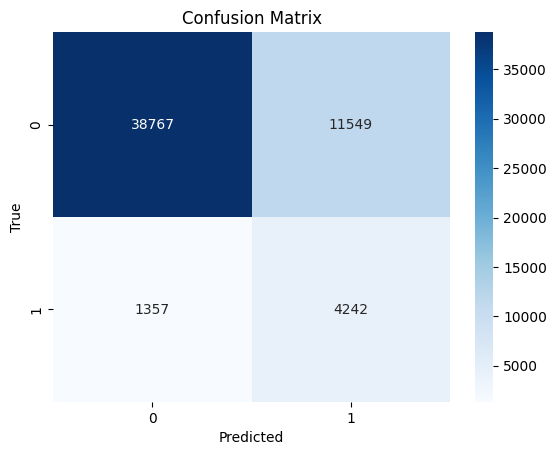

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     50316
           1       0.27      0.76      0.40      5599

    accuracy                           0.77     55915
   macro avg       0.62      0.76      0.63     55915
weighted avg       0.90      0.77      0.81     55915



In [12]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test)

## Data + feature

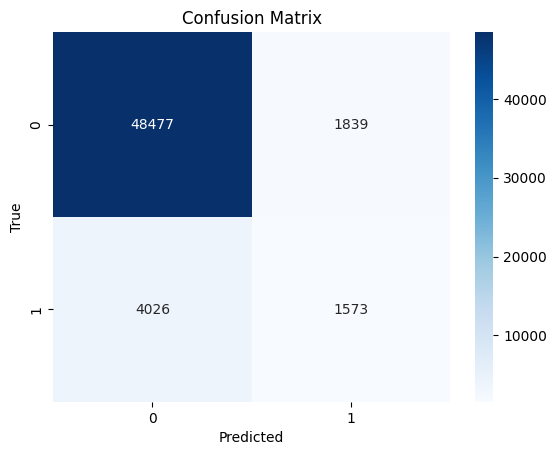

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     50316
           1       0.46      0.28      0.35      5599

    accuracy                           0.90     55915
   macro avg       0.69      0.62      0.65     55915
weighted avg       0.88      0.90      0.88     55915



In [13]:
train_and_evaluate_rf(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + Feature + Tune

[I 2025-05-05 18:04:58,754] A new study created in memory with name: no-name-162ca1cd-51f7-4698-aa58-38e76d155c49
[I 2025-05-05 18:06:26,306] Trial 0 finished with value: 0.3413635940842712 and parameters: {'n_estimators': 179, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.55}. Best is trial 0 with value: 0.3413635940842712.
[I 2025-05-05 18:08:27,546] Trial 1 finished with value: 0.3572200216060497 and parameters: {'n_estimators': 254, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.45000000000000007}. Best is trial 1 with value: 0.3572200216060497.
[I 2025-05-05 18:10:35,013] Trial 2 finished with value: 0.2456191588785047 and parameters: {'n_estimators': 244, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0

Best trial:
FrozenTrial(number=9, state=1, values=[0.38700920014076723], datetime_start=datetime.datetime(2025, 5, 5, 18, 21, 38, 351184), datetime_complete=datetime.datetime(2025, 5, 5, 18, 22, 24, 500837), params={'n_estimators': 128, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=9, value=None)
Best hyperparameters:
n_es

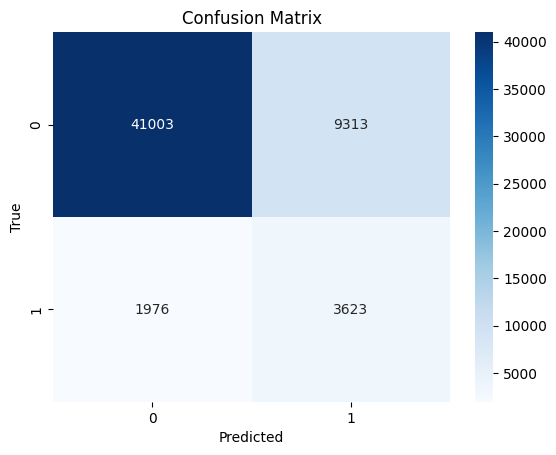

              precision    recall  f1-score   support

           0       0.95      0.81      0.88     50316
           1       0.28      0.65      0.39      5599

    accuracy                           0.80     55915
   macro avg       0.62      0.73      0.63     55915
weighted avg       0.89      0.80      0.83     55915



In [14]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

# SMOTE

In [15]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE 

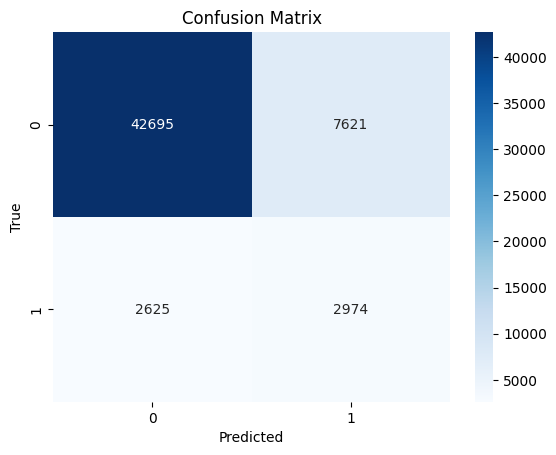

              precision    recall  f1-score   support

           0       0.94      0.85      0.89     50316
           1       0.28      0.53      0.37      5599

    accuracy                           0.82     55915
   macro avg       0.61      0.69      0.63     55915
weighted avg       0.88      0.82      0.84     55915



In [16]:
train_and_evaluate_rf(X_train_scaled, y_sm, X_test_scaled, y_test)

## Data SMOTE + Tune

[I 2025-05-05 18:34:38,354] A new study created in memory with name: no-name-84a96696-b885-498a-a56f-13046551a0a1
[I 2025-05-05 18:36:10,403] Trial 0 finished with value: 0.22559493412317433 and parameters: {'n_estimators': 112, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.22559493412317433.
[I 2025-05-05 18:44:11,747] Trial 1 finished with value: 0.11094502574323202 and parameters: {'n_estimators': 300, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.9}. Best is trial 0 with value: 0.22559493412317433.
[I 2025-05-05 18:48:19,220] Trial 2 finished with value: 0.1258626355570161 and parameters: {'n_estimators': 233, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold':

Best trial:
FrozenTrial(number=3, state=1, values=[0.3620813683958117], datetime_start=datetime.datetime(2025, 5, 5, 18, 48, 19, 220945), datetime_complete=datetime.datetime(2025, 5, 5, 18, 51, 53, 854473), params={'n_estimators': 163, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=3, value=None)
Best hyperparameters:
n_est

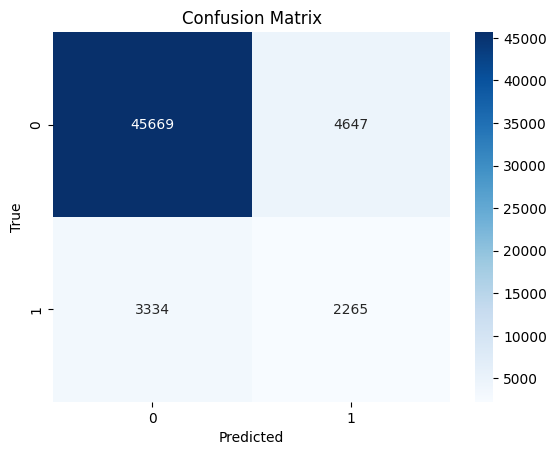

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     50316
           1       0.33      0.40      0.36      5599

    accuracy                           0.86     55915
   macro avg       0.63      0.66      0.64     55915
weighted avg       0.87      0.86      0.86     55915



In [17]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, use_smote=True)

## Data SMOTE + Feature

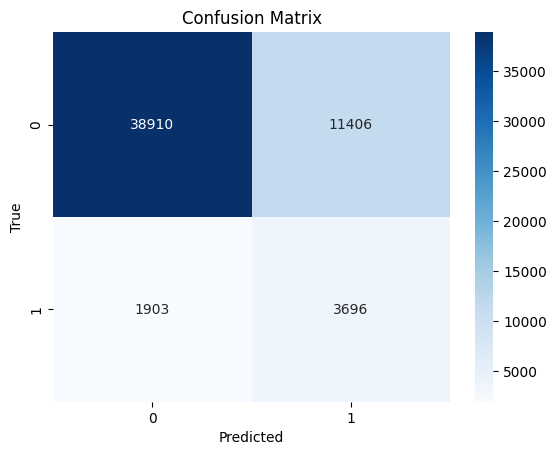

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     50316
           1       0.24      0.66      0.36      5599

    accuracy                           0.76     55915
   macro avg       0.60      0.72      0.61     55915
weighted avg       0.88      0.76      0.80     55915



In [18]:
train_and_evaluate_rf(X_train_scaled, y_sm, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE + Feature + Tune

[I 2025-05-05 19:05:58,510] A new study created in memory with name: no-name-d3d2395c-d367-402e-bd4d-07c584201d2d
[I 2025-05-05 19:10:46,927] Trial 0 finished with value: 0.345322259592285 and parameters: {'n_estimators': 265, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.4}. Best is trial 0 with value: 0.345322259592285.
[I 2025-05-05 19:14:08,851] Trial 1 finished with value: 0.23556097665361328 and parameters: {'n_estimators': 227, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.345322259592285.
[I 2025-05-05 19:17:48,458] Trial 2 finished with value: 0.2038576593440878 and parameters: {'n_estimators': 202, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.1}

Best trial:
FrozenTrial(number=4, state=1, values=[0.359493670886076], datetime_start=datetime.datetime(2025, 5, 5, 19, 20, 2, 596114), datetime_complete=datetime.datetime(2025, 5, 5, 19, 23, 48, 386005), params={'n_estimators': 191, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.45000000000000007}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=4, value=None)
Best hyperpara

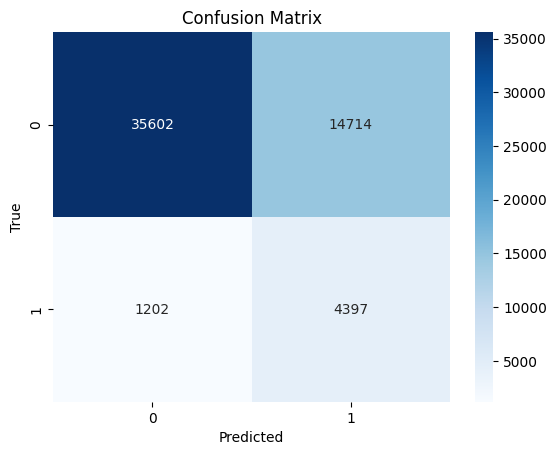

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     50316
           1       0.23      0.79      0.36      5599

    accuracy                           0.72     55915
   macro avg       0.60      0.75      0.59     55915
weighted avg       0.89      0.72      0.77     55915



In [19]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, top_features=top_features, use_smote = True)

# SMOTE ENN

In [20]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE ENN 

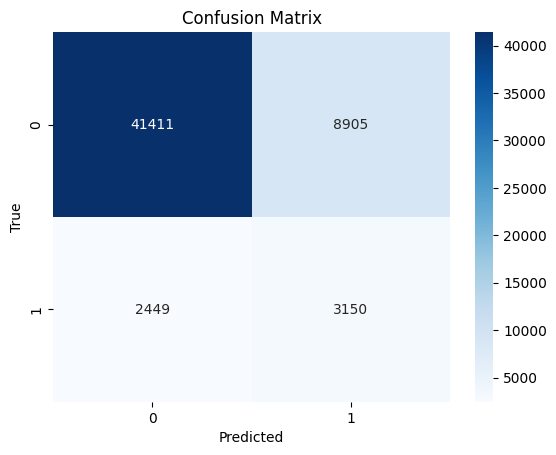

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     50316
           1       0.26      0.56      0.36      5599

    accuracy                           0.80     55915
   macro avg       0.60      0.69      0.62     55915
weighted avg       0.88      0.80      0.83     55915



In [21]:
train_and_evaluate_rf(X_train_scaled, y_smenn, X_test_scaled, y_test)

## Data SMOTE ENN + Tune

[I 2025-05-05 19:46:05,462] A new study created in memory with name: no-name-8c6d0400-40ad-4856-b1a5-7ed5aa6be8c9
[I 2025-05-05 19:49:22,423] Trial 0 finished with value: 0.22257829570284052 and parameters: {'n_estimators': 150, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.85}. Best is trial 0 with value: 0.22257829570284052.
[I 2025-05-05 19:53:44,478] Trial 1 finished with value: 0.26389529660296723 and parameters: {'n_estimators': 249, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.2}. Best is trial 1 with value: 0.26389529660296723.
[I 2025-05-05 19:56:25,318] Trial 2 finished with value: 0.3438433950986252 and parameters: {'n_estimators': 152, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.6}. Best is 

Best trial:
FrozenTrial(number=3, state=1, values=[0.3613980716253444], datetime_start=datetime.datetime(2025, 5, 5, 19, 56, 25, 319609), datetime_complete=datetime.datetime(2025, 5, 5, 19, 59, 45, 972378), params={'n_estimators': 154, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=3, value=None)
Best hyperparameters:
n_est

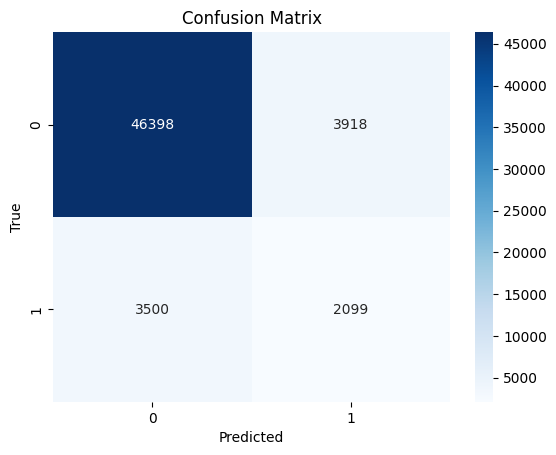

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     50316
           1       0.35      0.37      0.36      5599

    accuracy                           0.87     55915
   macro avg       0.64      0.65      0.64     55915
weighted avg       0.87      0.87      0.87     55915



In [22]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, use_smoteenn = True)

## Data SMOTE ENN + Feature

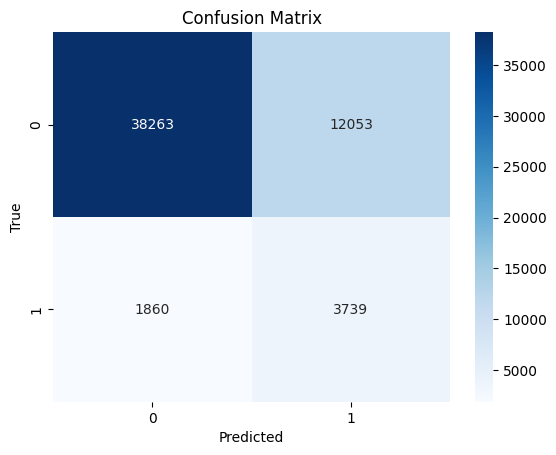

              precision    recall  f1-score   support

           0       0.95      0.76      0.85     50316
           1       0.24      0.67      0.35      5599

    accuracy                           0.75     55915
   macro avg       0.60      0.71      0.60     55915
weighted avg       0.88      0.75      0.80     55915



In [23]:
train_and_evaluate_rf(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE ENN + Feature + Tune

[I 2025-05-05 20:17:11,105] A new study created in memory with name: no-name-5ae138c4-c596-462e-b4af-7ff79b2e8e14
[I 2025-05-05 20:19:28,382] Trial 0 finished with value: 0.31294588221247127 and parameters: {'n_estimators': 129, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.31294588221247127.
[I 2025-05-05 20:22:18,206] Trial 1 finished with value: 0.2609697551608257 and parameters: {'n_estimators': 154, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.2}. Best is trial 0 with value: 0.31294588221247127.
[I 2025-05-05 20:25:29,176] Trial 2 finished with value: 0.33202169520365843 and parameters: {'n_estimators': 253, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold':

Best trial:
FrozenTrial(number=2, state=1, values=[0.33202169520365843], datetime_start=datetime.datetime(2025, 5, 5, 20, 22, 18, 207674), datetime_complete=datetime.datetime(2025, 5, 5, 20, 25, 29, 176408), params={'n_estimators': 253, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'threshold': 0.85}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=100, step=1), 'max_depth': IntDistribution(high=30, log=False, low=10, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'class_weight': CategoricalDistribution(choices=('balanced_subsample',)), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step=0.05)}, trial_id=2, value=None)
Best hyperparameters:
n_es

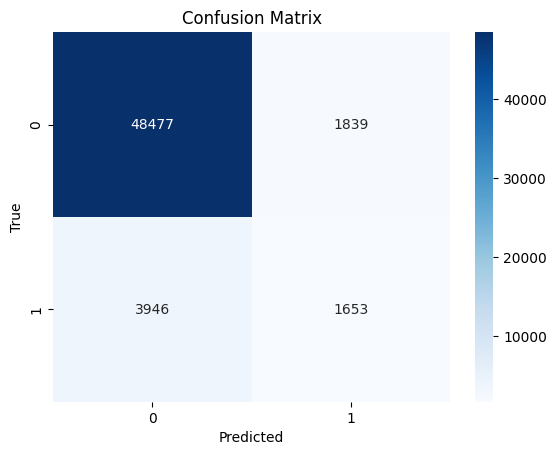

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     50316
           1       0.47      0.30      0.36      5599

    accuracy                           0.90     55915
   macro avg       0.70      0.63      0.65     55915
weighted avg       0.88      0.90      0.89     55915



In [24]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features=top_features,  use_smoteenn = True)